## Problem Definition

### **Business Context**
**Spark7 Inc.** is a Telecommunication services company which has been in the international market for close to 2 years. Server outages (even for a few hours) in this industry can lead to costly business disasters, and operating inefficiently can add to the costs further. 

Owing to this, Spark7 Inc. wants to setup a Statistical Process in place which can help with two things: 

* Detect abnormal spikes or dips in the server requests and send an alert to their Tech Team to queue requests or to check for possible system failures or bugs which can lead to the server going offline

* Monitor the incoming traffic and proactively scale up or scale down based on the load

### **Objective**
You are an Analytics Engineer working with Spark7 Inc. and your objective is to design an Anomaly Detection Algorithm using Statistical Process Control which can monitor the incoming network requests in real-time and alert the Tech Team to take action on the above mentioned points.

#### **Solution Approach**
On a typical day, Spark7 gets an **average** of **3600** requests and the server running on it's DEFAULT configuration can handle a **deviation** of **900** requests. Using this information, we can define a set of rules which can alert the Tech Team to take appropriate action.



### Data Dictionary

**requests.csv** is a training dataset which has been provided to you for the purpose of creating and testing out the Anomaly Detection Algorithm. This dataset has close to 3 days of incoming requests along with the timestamp of when the current number of requests was recorded.

* timestamp (datetime): Request log time every 15 minutes
* requests (integer): Number of requests at the time of recording

## 1.0 Defining the Control Limits

The server typically has around **3600** active requests at a given time and the DEFAULT configuration of the server can handle a deviation of **900** requests. Using this information provided, let's calculate the control limits as shown below:

$\mu$ + 3$\sigma$ = 6300

$\mu$ + 2$\sigma$ = 5400

$\mu$ + $\sigma$ = 4500

$\mu$ = 3600

$\mu$ - $\sigma$ = 2700

$\mu$ - 2$\sigma$ = 1800

$\mu$ - 3$\sigma$ = 900

### 1.1 Import libraries


In [2]:
# Import libraries for data manipulation
import numpy as np
import pandas as pd

# Import libraries for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Import libraries for simulating real-time detection
import time
!pip install colorama
import colorama
from colorama import Fore,Style

### 1.2 Calculating the Control Limits

In [3]:
# Create variables to store mu and sigma
mu = 3600
sigma = 900

In [4]:
# Create variables to store control limits
mu_pls_1sigma = mu + sigma
mu_min_1sigma = mu - sigma

mu_pls_2sigma = mu + 2*sigma
mu_min_2sigma = mu - 2*sigma

mu_pls_3sigma = mu + 3*sigma
mu_min_3sigma = mu - 3*sigma

### 1.3 Function to create SPC chart

In [5]:
def plot_spc():
    '''
    Function to plot a Statistical Process Control chart. When used alone, 
    it plots an empty canvas with all the control limits specified
    '''
    # define x and y lables
    plt.ylabel('requests')
    plt.xlabel('timestamp')

    # Create a x-line for each control limit
    plt.axhline(y=mu_pls_3sigma, linestyle='--', color='#BB0A21', label='UCL = '+ str(mu_pls_3sigma))
    plt.axhline(y=mu_pls_2sigma, linestyle='--', color='#4b88a2', label='2-sigma UL = '+ str(mu_pls_2sigma))
    plt.axhline(y=mu_pls_1sigma, linestyle='--', color='#252627', label='1-sigma UL = '+ str(mu_pls_1sigma))
    plt.axhline(y=mu, color='#003459', label='Mean = '+ str(mu))
    plt.axhline(y=mu_min_1sigma, linestyle='--', color='#252627', label='1-sigma LL = '+ str(mu_min_1sigma))
    plt.axhline(y=mu_min_2sigma, linestyle='--', color='#4b88a2', label='2-sigma LL = '+ str(mu_min_2sigma))
    plt.axhline(y=mu_min_3sigma, linestyle='--', color='#BB0A21', label='LCL = '+ str(mu_min_3sigma))
    
    # Plot the above lines with a legend
    plt.legend()
    plt.show()

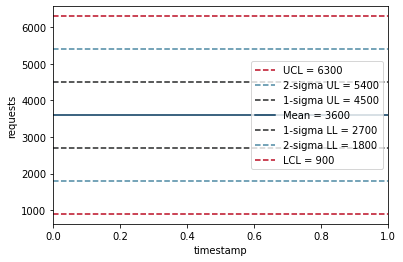

In [6]:
# Plot the empty SPC chart
plot_spc()

## 2.0 Read Data

In [7]:
# Upload the dataset into google colab's working directory
from google.colab import files
import io

try:
    uploaded
except NameError:
    uploaded = files.upload()

req_df = pd.read_csv('requests.csv')    

Saving requests.csv to requests (1).csv


In [8]:
req_df.head()

,timestamp,requests
0,01-01-2021 00:00,3530
1,01-01-2021 00:15,3330
2,01-01-2021 00:30,4064
3,01-01-2021 00:45,3465
4,01-01-2021 01:00,3524


## 3.0 Defining the rules for Anomaly Detection

### 3.1 Function to detect Anomalies



**Note:** If you are learning this for the first time, it is recommended that you just define this function for now and move on to the further sections. The way this function was built will become clear as you understand how it works in the coming sections.

In [9]:
def detect_anomaly(n):
    '''
    Function to flag anomalies in the data. This function can be used to flag
    3 types of anomalies:

    0 - Show just the data
    1 - Points that are between mu +/- 1*sigma and mu +/- 2*sigma
    2 - Points that are between mu +/- 2*sigma and mu +/- 3*sigma
    3 - Points that go beyond UCL or LCL (beyond mu +/- 3*sigma)
    4 - All 1, 2 and 3 mentioned above at once
    '''

    # Initialize the filters for the 3 types of Anomalies
    x = req_df['requests']
    filter_1 = ( (x > mu_pls_1sigma) & (x < mu_pls_2sigma) ) | ( (x < mu_min_1sigma) & (x > mu_min_2sigma) )
    filter_2 = ( (x > mu_pls_2sigma) & (x < mu_pls_3sigma) ) | ( (x < mu_min_2sigma) & (x > mu_min_3sigma) )
    filter_3 = (x > mu_pls_3sigma) | (x < mu_min_3sigma)
    
    # Show just the trend
    if n==0:
        fig, ax = plt.subplots(figsize = (20, 9))
        ax.plot(req_df['requests'], linestyle='-', marker='.', color='#3A4E48', linewidth=1)
        plot_spc()
    
    # Points that are between mu +/- 1*sigma and mu +/- 2*sigma
    elif n==1:
        fig, ax = plt.subplots(figsize = (20, 9))
        ax.plot(x[filter_1], 'o', color='#A4031F', markersize=7)
        ax.plot(req_df['requests'], linestyle='-', marker='.', color='#3A4E48', linewidth=1)
        plot_spc()
    
    # Points that are between mu +/- 2*sigma and mu +/- 3*sigma
    elif n==2:
        fig, ax = plt.subplots(figsize = (20, 9))
        ax.plot(x[filter_2], 'o', color='#A4031F', markersize=7)
        ax.plot(req_df['requests'], linestyle='-', marker='.', color='#3A4E48', linewidth=1)
        plot_spc()
    
    # Points that go beyond UCL or LCL (beyond mu +/- 3*sigma)
    elif n==3:
        fig, ax = plt.subplots(figsize = (20, 9))
        ax.plot(x[filter_3], 'o', color='#A4031F', markersize=7)
        ax.plot(req_df['requests'], linestyle='-', marker='.', color='#3A4E48', linewidth=1)
        plot_spc()

    # All 1, 2 and 3 mentioned above at once
    elif n==4:
        fig, ax = plt.subplots(figsize = (20, 9))
        ax.plot(x[filter_1], 'o', color='#A4031F', markersize=7)
        ax.plot(x[filter_2], 'o', color='#A4031F', markersize=7)
        ax.plot(x[filter_3], 'o', color='#A4031F', markersize=7)
        ax.plot(req_df['requests'], linestyle='-', marker='.', color='#3A4E48', linewidth=1)
        plot_spc()

### 3.2 Identifying patterns in the trend

**Ask Yourself:** What patterns do you see in below data? Think about how to create an algorithm to flag datapoints that are not following the normal path

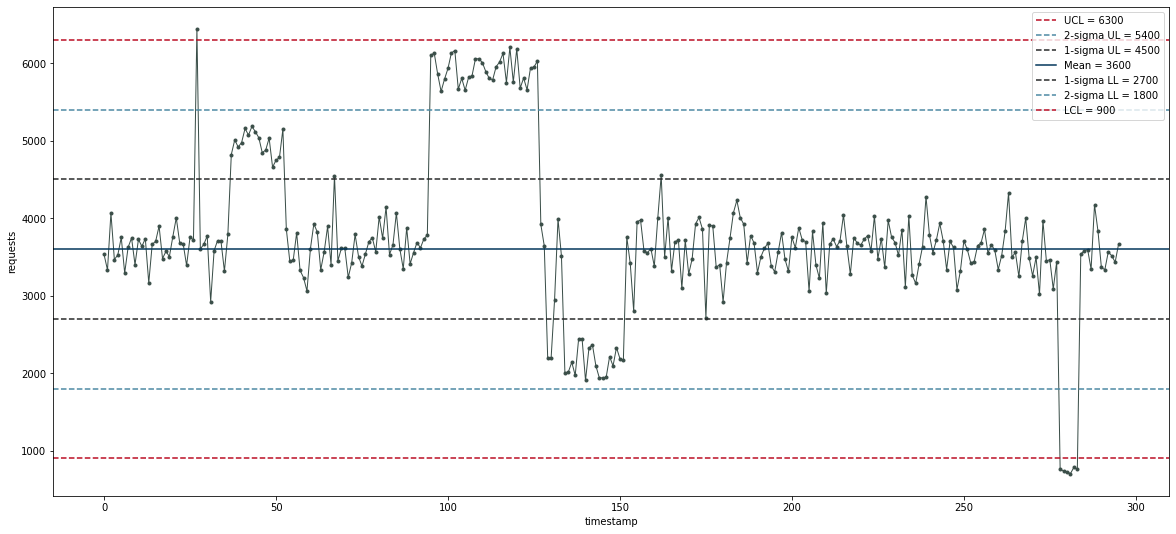

In [15]:
detect_anomaly(0)

### 3.3 Flagging Anomalies in the data

There are 3 kinds of anomalies you can flag:

**Type 1**: When the datapoint is between $\mu$ $\pm$ $\sigma$ and $\mu$ $\pm$ 2$\sigma$

**Type 2**: When the datapoint is between $\mu$ $\pm$ 2$\sigma$ and $\mu$ $\pm$ 3$\sigma$

**Type 3**: When the datapoint goes outside the range of UCL or LCL ($\mu$ $\pm$ 3$\sigma$)

You can change the number in the below function call to see these anomalies getting flagged.

* 0 - Show just the trend
* 1 - Points that are between $\mu$ $\pm$ $\sigma$ and $\mu$ $\pm$ 2$\sigma$
* 2 - Points that are between $\mu$ $\pm$ 2$\sigma$ and $\mu$ $\pm$ 3$\sigma$
* 3 - Points that go beyond UCL or LCL ($\mu$ $\pm$ 3$\sigma$)
* 4 - All types of anomalies mentioned above at once

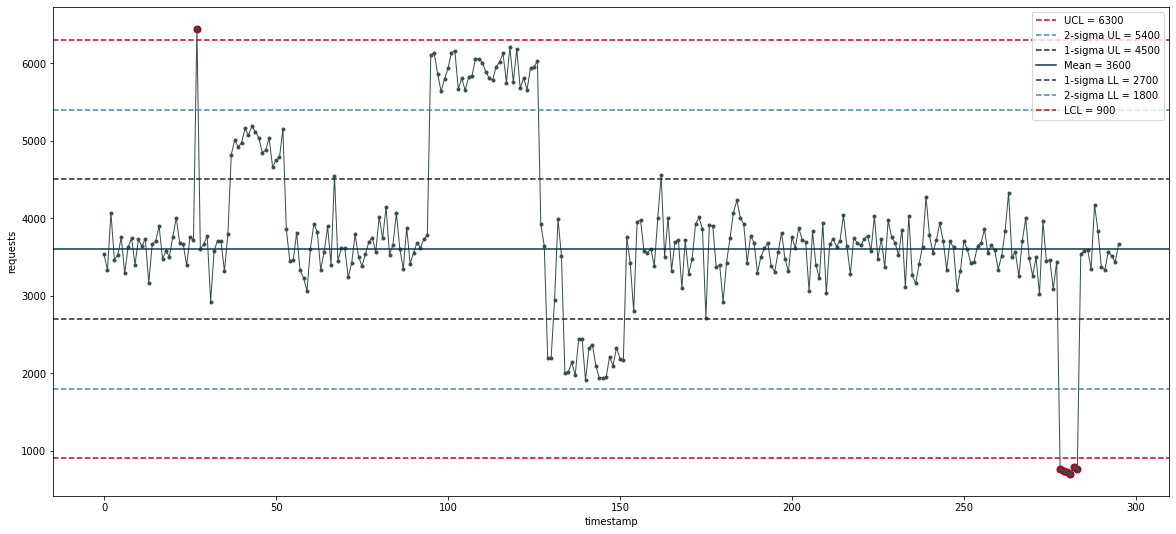

In [14]:
detect_anomaly(3) 

## 4.0 Simulating real-time Anomaly Detection

Let's set the ground rules for sending alerts to the Tech Team!

**Problem-1**: The first kind of alert we need to send to the Tech team is when the requests cross the Upper or Lower limit ($\mu$ $\pm$ 3$\sigma$). 

If this is above the upper limit (greater than $\mu$ + 3$\sigma$), they can control the requests by queuing them so that the server does not crash due to the overload.

If this is below the lower limit (lesser than $\mu$ - 3$\sigma$), they can investigate to see if this is genuine or if there are any system glitches and can resolve them before the server goes offline.

**Problem-2**: The second kind of alert we need to send is when we need to upscale or downscale our server capacity when the requests are persistently high or low.

When more than 8 datapoints continuously occur between $\mu$ $\pm$ $\sigma$ and $\mu$ $\pm$ 2$\sigma$, you can send instructions to upscale or downscale the capacity by **1 Level**.

When more than 4 datapoints continuously occur between $\mu$ $\pm$ 2$\sigma$ and $\mu$ $\pm$ 3$\sigma$, you can send instructions to upscale or downscale the capacity by **2 Levels**. 

### 4.1 Function to simulate real-time Anomaly Detection

**Note:** It's recommended that you just define this function and then jump to section **4.2** and see Anomaly Detection in Action first. You can then come back to see how this function accomplishes that.

In [18]:
def simulateAD(df):

  # Initialize counters to Zero
  type_1_cnt = type_2_cnt = 0

  for i in range(len(df)): # for every datapoint that comes in, do the below
      
      # Capture the requests and the timestamp
      req = df['requests'][i]
      tms = str(df['timestamp'][i])
      
      # Initialize the Anomaly Type Flags to Zero
      type_1 = type_2 = type_3 = 0

      # Points that are between mu +/- 1*sigma and mu +/- 2*sigma
      if ( (req > mu_pls_1sigma) and (req < mu_pls_2sigma) ) or \
         ( (req < mu_min_1sigma) and (req > mu_min_2sigma) ):
        type_1 = 1
      
      # Points that are between mu +/- 2*sigma and mu +/- 3*sigma
      if ( (req > mu_pls_2sigma) and (req < mu_pls_3sigma) ) or \
         ( (req < mu_min_2sigma) and (req > mu_min_3sigma) ):
        type_2 = 1

      # Points that go beyond UCL or LCL (beyond mu +/- 3*sigma)
      if (req > mu_pls_3sigma) or (req < mu_min_3sigma): 
        type_3 = 1
      
      # Message / Action for Type 1 Anomaly
      if type_1 == 1:
        type_2_cnt = 0 # reset type 2 counter
        if type_1_cnt >= 8:
          print(tms + ': ' + str(req) + ' requests received' + ' \033[1m(SCALE UP/DOWN BY 1 LEVEL)', 'and persist', Style.RESET_ALL)
        else:
          print(tms + ': ' + str(req) + ' requests received' + ' (stand-by to scale up or down by 1 level)')
        type_1_cnt = type_1_cnt + 1
      
      # Message / Action for Type 2 Anomaly
      elif type_2 == 1:
        type_1_cnt = 0 # reset type 1 counter
        if type_2_cnt >= 4:
          print(tms + ': ' + str(req) + ' requests received' + ' \033[1m(SCALE UP/DOWN BY 2 LEVELS)', 'and persist', Style.RESET_ALL)
        else:
          print(tms + ': ' + str(req) + ' requests received' + ' (stand-by to scale up or down by 2 levels)')    
        type_2_cnt = type_2_cnt + 1
      
      # Message / Action for Type 3 Anomaly
      elif type_3 == 1:
        type_1_cnt = type_2_cnt = 0 # reset both type 1 and type 2 counters
        print(tms + ': ' + Fore.RED + "\033[1m[!] CRITICAL: number of requests are outside limits:", str(req), Style.RESET_ALL)
        
      # Normal Functioning
      else:
        type_1_cnt = type_2_cnt = 0 # reset both type 1 and type 2 counters
        print(tms + ': ' + str(req) + ' requests received' + ' (within control - stay in or switch back to DEFAULT LEVEL)')
        
      # In real time, each datapoint would come in every 15 minutes
      # As we cannot wait so long, lets scale that down to 0.3 seconds
      time.sleep(0.3)

### 4.2 Anomaly Detection in Action!

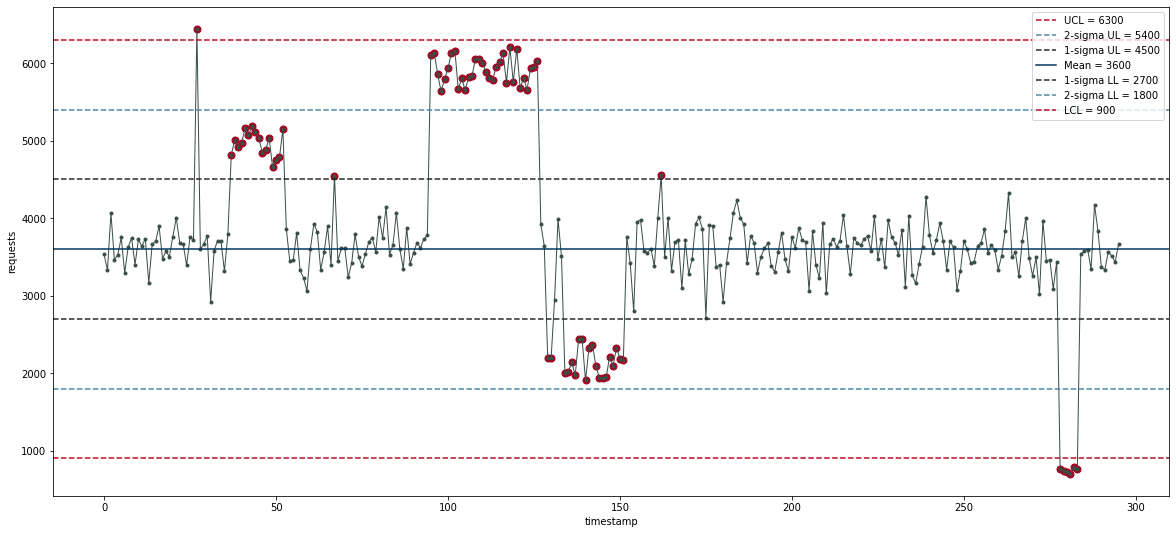

01-01-2021 00:00: 3530 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 00:15: 3330 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 00:30: 4064 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 00:45: 3465 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 01:00: 3524 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 01:15: 3750 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 01:30: 3291 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 01:45: 3623 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 02:00: 3743 requests received (within control - stay in or switch back to DEFAULT LEVEL)
01-01-2021 02:15: 3399 requests received (within control - stay in or switch back to DEFAULT LEVEL)


KeyboardInterrupt: ignored

In [19]:
detect_anomaly(4) 
simulateAD(req_df)

***